In [1]:
!pip install -q git+https://github.com/huggingface/transformers@21fac7abba2a37fae86106f87fcf9974fd1e3830 accelerate
!pip install -q optimum
!pip install -q auto-gptq
!pip install -q qwen-vl-utils[decord]

In [2]:
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info

In [3]:
model_id = "/kaggle/input/qwen2-vl/transformers/qwen2-vl-2b-instruct-gptq-int4/1"
model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_id, torch_dtype="auto", device_map="auto"
)
processor = AutoProcessor.from_pretrained(model_id)

/opt/conda/lib/python3.10/site-packages/transformers/modeling_utils.py:4728: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(


In [ ]:
prompt = '''
This is an AI generated image. Give a description of why the image is AI generated. Provide all the reasons which you can find that it might be fake
# List of Artifacts

- Inconsistent object boundaries
- Discontinuous surfaces
- Non-manifold geometries in rigid structures
- Floating or disconnected components
- Asymmetric features in naturally symmetric objects 
- Misaligned bilateral elements in animal faces 
- Irregular proportions in mechanical components 
- Texture bleeding between adjacent regions
- Texture repetition patterns
- Over-smoothing of natural textures 
- Artificial noise patterns in uniform surfaces
- Unrealistic specular highlights
- Inconsistent material properties
- Metallic surface artifacts 
- Dental anomalies in mammals 
- Anatomically incorrect paw structures
- Improper fur direction flows
- Unrealistic eye reflections
- Misshapen ears or appendages
- Impossible mechanical connections
- Inconsistent scale of mechanical parts
- Physically impossible structural elements
- Inconsistent shadow directions
- Multiple light source conflicts
- Missing ambient occlusion
- Incorrect reflection mapping
- Incorrect perspective rendering
- Scale inconsistencies within single objects
- Spatial relationship errors
- Depth perception anomalies
- Over-sharpening artifacts
- Aliasing along high-contrast edges
- Blurred boundaries in fine details
- Jagged edges in curved structures
- Random noise patterns in detailed areas
- Loss of fine detail in complex structures
- Artificial enhancement artifacts
- Incorrect wheel geometry
- Implausible aerodynamic structures
- Misaligned body panels
- Impossible mechanical joints
- Distorted window reflections
- Anatomically impossible joint configurations
- Unnatural pose artifacts
- Biological asymmetry errors
- Regular grid-like artifacts in textures
- Repeated element patterns
- Systematic color distribution anomalies
- Frequency domain signatures
- Color coherence breaks
- Unnatural color transitions
- Resolution inconsistencies within regions
- Unnatural Lighting Gradients
- Incorrect Skin Tones
- Fake depth of field
- Abruptly cut off objects
- Glow or light bleed around object boundaries
- Ghosting effects: Semi-transparent duplicates of elements
- Cinematization Effects
- Excessive sharpness in certain image regions
- Artificial smoothness
- Movie-poster like composition of ordinary scenes
- Dramatic lighting that defies natural physics
- Artificial depth of field in object presentation
- Unnaturally glossy surfaces
- Synthetic material appearance
- Multiple inconsistent shadow sources
- Exaggerated characteristic features
- Impossible foreshortening in animal bodies
- Scale inconsistencies within the same object class



here are the things you will tell me if the image is fake, which of these are present in the image, and provide description of each artifact you find
'''

"data:image;base64,"

In [4]:
from PIL import Image
import base64
import io
import matplotlib.pyplot as plt


# Path to the local image
local_image_path = "/kaggle/input/cifake-test/1019 (2).jpg"

image = Image.open(local_image_path)
resized_image = image.resize((256, 256), Image.LANCZOS)

output_image_path = "/kaggle/working/resized_image_dog.jpg"
resized_image.save(output_image_path)

# Open and encode the local image
with open(local_image_path, "rb") as img_file:
    encoded_image = base64.b64encode(img_file.read()).decode("utf-8")
# resized_image.show()

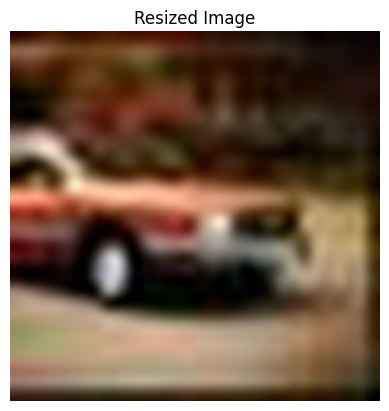

In [5]:
plt.imshow(resized_image)
plt.axis("off")  # Turn off axis labels
plt.title("Resized Image")
plt.show()

In [40]:
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": "data:image;base64,"+encoded_image,
                # "resized_height": 32,
                # "resized_width": 32,
            },
            {"type": "text", "text":"Your job is to help them identify AI generated content. This is an AI generated image. Give me the artifacts you can find in the image which might reveal why it is fake."},
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=2048)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)

['The image appears to be a manipulated or edited photo. Here are some artifacts that might reveal why it is fake:\n\n1. **Blurred Background**: The background is blurred, which suggests that the photo was taken with a low-resolution camera or with a filter that reduces the clarity of the background.\n2. **Inaccurate Lighting**: The lighting in the image is not realistic, which could indicate that the photo was taken with a different camera or lighting setup.\n3. **Inconsistent Colors**: The colors in the image are not consistent, which could suggest that the photo was edited or that the original image was taken with a different camera or lighting setup.\n4. **Inaccurate Composition**: The composition of the image is not realistic, which could indicate that the photo was edited or that the original image was taken with a different camera or lighting setup.\n5. **Inconsistent Scale**: The scale of the image is not consistent, which could indicate that the photo was edited or that the or

In [ ]:
" Artifacts may include but not limited to, surface inconsistencies, colour errors, anatomical errors in animals, and maybe even physically impossible things."